In [1]:
import rps.robotarium as robotarium
from rps.utilities.transformations import *
from rps.utilities.barrier_certificates import *
from rps.utilities.misc import *
from rps.utilities.controllers import *

import numpy as np
import scipy.stats as st
import time

In [2]:
#Defining the input axes
# Note: the boundaries for the control actions are the actuation constraints imposed by the physics of the robots

control_space_size = 3  # Three possible inputs for each control axis

U_space_1 = np.array(np.linspace((-0.5),(0.5),control_space_size))  #[-0.5  0.   0.5] Prima dimensione spaziale dell'ambiente di simulazione Robotarium
U_space_2 = np.array(np.linspace((-0.5),(0.5),control_space_size)) # [-0.5  0.   0.5] Seconda dimensione spaziale dell'ambiente di simulazione Robotarium
time_step = 0.033 # Robotarium time-step (from the documentation) 

In [3]:
# This function performs a "model" step using the documented dynamics
# Note: from the viewpoint of the controller the dynamics is not necesarily known

# Questa funzione esegue un passo del "modello" utilizzando le dinamiche documentate. 
# Prende in input la posizione attuale x, le velocità  e l'intervallo di tempo time_step. 
# Aggiorna la posizione dei robot calcolando le nuove coordinate come la somma delle coordinate attuali e del prodotto 
# tra l'intervallo di tempo e le rispettive velocità lungo le direzioni x e y. Restituisce le nuove coordinate aggiornate come un
# array di dimensione (2,1).
def model_step(x,velocities,time_step):
    """_summary_

    Args:
        x (float): posizione attuale del robot
        velocities (float): velocità del robot
        time_step (_type_): intervallo di tempo per eseguire uno step del modello
    """
    poses = np.zeros((2,1))
    # Update pose of the robots
    poses[0] = x[0] + time_step*velocities[0]
    poses[1] = x[1] + time_step*velocities[1]
    return(poses)

#Get the value of a Gaussian pf at a given point ?
#Questa funzione calcola il valore di una funzione di densità di probabilità (PDF) gaussiana in un punto specifico.
# Prende in input il punto di valutazione x, il valore medio della distribuzione gaussiana u e la matrice di covarianza covar. 
# La funzione inizia calcolando la dimensione k del punto x. Quindi calcola alcuni passaggi intermedi utilizzando i valori trasposti,
# l'inverso della matrice di covarianza e la differenza tra il punto x e il valore medio u. Successivamente, calcola il numeratore e il 
# denominatore della formula della distribuzione gaussiana multivariata e restituisce il valore della PDF gaussiana in quel punto specifico.
# In questo caso la funzione in esame è una gaussiana multi-variata per calcolare il valore della densità di probabilità in un punto 

def my_logpdf(x, u, covar): 
    """_summary_

    Args:
        x (float): punto di valutazione della pdf
        u (float): valore medio della pdf
        covar (float): matrice di covarianza della pdf

    Returns:
        float: pdf ottenuta dai dati campionata
    """
    # Calcola la dimensione del vettore
    k = len(x)  # dimension 
    # Calcola la differenza tra il punto di valutazione x e il valore medio u della distribuzione gaussiana, quindi prende la sua trasposta
    a = np.transpose(x - u) 
    #Calcola l'inversa della matrice di covarianza
    b = np.linalg.inv(covar) 
    #Calcola la differenza tra il punto di valutazione x e il valore medio u.
    c = x - u 
    #Effettua la moltiplicazione matriciale tra a e b.
    d = np.matmul(a, b) 
    #Effettua la moltiplicazione matriciale tra d e c.
    e = np.matmul(d, c)
    #Calcola il numeratore della formula della distribuzione gaussiana. 
    numer = np.exp(-0.5 * e)
    #Calcola il termine costante del denominatore.
    f = (2 * np.pi)**k 
    g = np.linalg.det(covar) 
    #Calcola il denominatore della formula della distribuzione gaussiana.
    denom = np.sqrt(f * g) 
    #Calcola il valore della funzione di densità di probabilità (PDF) gaussiana multi-variata in base ai valori numerici precedentemente calcolati
    pdf = numer / denom 
    #f(x) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}
    #myLogpdf = \log f(x) = -\frac{1}{2} \log 2\pi - \log \sigma - \frac{(x-\mu)^2}{2\sigma^2}
    return pdf 





# WP0

In [4]:
##### WP0: formalize the control problem #####
#Per info sulla formulazione del problema vedere rimandi nel README

Problem set up
============

Let $X_k ∈ X ⊆ K_n$ be the system state at time step k and $Uk ∈ U ⊆ K_p$ be the control input at time step k. Time indexing is chosen so that the system switches to $x_k$ when $u_k$ is applied. That is, making the standard Markovian assumption, the possibly nonstationary and nonlinear stochastic dynamics for the system under control is described by the pf $p(x) := p(x) (x_k | u_k,x_{k−1})$. We will call this pf as target pf.

To formalize the control problem we introduce the pf:
 $p_{0:N} =p_0(x_0)\Pi(p_{k|k−1}) =p_0(x_0)\Pi(p^{(x)}_{k|k-1}*p^ {(u)}_{k|k-1})$\
 where: $p^{(u)}_{k|k−1}:= p_{(u)}(u_k | x_{k−1})$ is a randomized policy and the initial conditions are incorporated via the prior $p_0(x_0)$.
Furthermore, we use the shorthand notation $p^{(x)}_{k|k−1}p^{(u)}_{k|k−1}=p(x_k,u_k|x_{k-1} )$

Furthermore, let us remember that the pf $p_{0:N}$ describes in probabilistic terms the evolution of the closed-loop system when, at every k, a given
policy, let's say $p_k^{(u)}(u_k|x_{k-1})$ is used.
With the forward control problem formalized next we aim to design the policy. This policy is then exploited to address the inverse problem where we try to estimate the cost.

## Forward control problem
Let $c_k : X → R$ be the cost, at time step k, associated with a given state $x_k$. Then, the expected cost incurred when the system is in state $x_{k−1}$ and input $u_k$ is applied is given by $E_{p_{k|k-1}^{(x)}}[c_k(X_k )]$ . The advanced control problem considered in this file is formalized with the following:

Given a pdf joint: $q_{0:N} := q_0 (x_0) \Pi q^{(x)} (x_k | u_k, x_{k−1}) q_k^{(u)} (u_k | x_ {k−1})$ find the pdf sequence ${p_{k|k-1}^{(u)}}^*$ such that ${p_{k|k-1}^{(u)} }^*_{1:N}\space \in arg\space min{D_{KL}(p_{0:N}||q_{0:N}+\sum E_{\tilde p_{k- 1: k}}[E_{p_{k|k-1}^{(x)}}c_k(X_k)])}$ with the following constraint: ${p_{k|k-1}^{(u)} }\space \space \in D \space \space \forall k \space \in \Gamma$. where $ \tilde p_{k−1:k} := p_{k−1}(x_{k−1}, u_k)$

The solution to the above problem is a sequence of randomized policies. At each k, the control input applied to the system, $u_k$ is sampled from $p_{k|k-1}^{(u)^*}$
Furthermore, we also remember that minimizing the first term is equivalent to minimizing the discrepancy between $p_{0:N}$ and $q_{0:N}$. Hence, the first term in the cost functional can be thought of as a regularizer, which influences the behavior of the closed-loop system towards the reference pf $q_{0:N}$ .

Usually $p_{0:N}$ can be viewed as a passive dynamic or it can be used to capture some desired behavior. We also note that the problem of making policy p similar to q is equivalent to the previous problem when we have zero cost.

Subsequently it is also useful to introduce $q_{k|k-1}^{(x)}= q_k^{(x)} (x_k | u_k, x_{k−1}), q^{(u)} = q ^{(u)} (u_[k | {k−1}]) $.
In the following steps we will mainly focus on the dependence of the cost of the previous problem on the decision variables, and we will denote the latter as ì: $ \Gamma{p_{k|k-1}^{(u)}}_{1:N} $

In the following analysis the assumption will be made that there is := $\{\tilde p_{k|k-1}^{(u)}\}_{1:N}$, $\tilde p_{k|k−1} := p(u_k | x_{k−1})$ which is feasible and is such that $ \Gamma{p_{k|k-1}^{(u)}}_{1:N}$ is bounded.

## Inverse control problem
The inverse control problem we consider consists of estimating the cost-to-go for the agent, say $\tilde c_k(·)$, and the agent's cost $c_k(·)$ given a set of states/inputs observed samples from $p^{(x)}_{k|k-1}$ and the agent's pèolicy. In what follows, we denote by $\hat x_k$ and $\hat u_k$ the observed state and control input at time step k.
Regarding the IOC we also consider that the cost-to-go is expressed as a linear combination of the features. It can be expressed as $ \tilde p(x_k)=-w_k^Th(x_k)$, where $[h_1(x_k).....h_f(x_k)]^T$ is the feature vector and $h_i: X\rightarrow R$ are known functions, with $i=1....f$ and $w_k=[w_{k,1}....w_{k,f}]^T $ is a vector of weights.

## A special case
### FOC

We note that in our case the KL-divergence component in the cost resulted from the following problem: $p_{0:N} =p_0(x_0)\Pi(p_{k|k−1}) =p_0(x_0)\Pi(p^{(x)}_{k|k-1}*p^{(u)}_{k|k-1})$ becomes an entropic regulator and consequently the optimal policy from the softmax function $p_{k|k-1}^{(u)}=\frac{\tilde p^{(u)}_{k|k-1}exp (-E_{p_{k|k-1}}[\tilde c(X_k)])}{\sum_{u_k}(\tilde p^{(u)}_{k|k-1}exp (-E_{p_{k|k-1}}[\tilde c(X_k)]))} $ becomes $p_{k|k-1}^{(u)}=\frac{exp(-E_{p_{k|k-1}}[\ln(\tilde p^{(u)}_{k|k-1})+\tilde c(X_k))]}{\sum_{u_k}exp(-E_{p_{k|k-1}}[\ln(\tilde p^{(u)}_{k|k-1})+\tilde c(X_k))]} $ where $c_k$ is given by the natural logarithm of the expected value of the summation of the exponentials having as argument the expected value calculated on policy p of state x at time k+1 given k of the natural logarithm of policy p added to the expected cost at time k+1 of the state relative to the time instant k+1, all changed in sign. Furthermore, in this particular configuration of the FOC the previously mentioned expected value is equal to 0.
### IOC
In the IOC the problem becomes: $argmin\{\sum_{k=1}^M(-E_{p(x_k|\hat x_{k-1},\hat u_K)}[w_k^Th(x_k)]) +\ln (\sum _{u_k} exp(E_{p(x_k|\hat x_{k-1},u_k)}[-\ln p(x_k|\hat x_{k-1},u_k])+w_k^Th(x_k)\}$

State_cost function

In [5]:
# Task: reverse engineer the cost function used by the robots. What is the problem formulation? 
#      Is the one below a good cost for the task? Create a heatmap to visualize the cost 


def state_cost(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar) # rappresenta la somma cumulativa delle valutazioni della funzione di densità di probabilità gaussiana multivariata. Questa somma viene calcolata per ciascun punto di ostacolo presente nella matrice obs_points. 
        #La funzione di densità di probabilità viene valutata per le coordinate dello stato corrente rispetto a ciascun punto di ostacolo con la matrice di covarianza covar. L'aggiunta di questi valori cumulativi alla variabile gauss_sum contribuisce al costo totale, influenzando il comportamento del robot nell'evitare gli ostacoli presenti nell'ambiente Robotarium
 
    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 10*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi))) 
    #(state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) represents the Euclidean distance between the current state and the goal point. This term encourages the robot to minimize its distance to the goal.
    #gauss_sum  represent the cost associated with the presence of obstacles. It involves the calculation of the multivariate Gaussian probability density function for each obstacle point.
    #additional terms: These terms are structured to penalize the robot for being in certain areas.
#The cost function incentivizes the robot to avoid obstacles and reach the goal as quickly as possible while penalizing it for being in specific regions of the environment 

    return(cost)

### Approccio di campionamento Monte Carlo
La seguente funzione per l'esecuzione del "passo" dell'algoritmo utilizza un approccio di campionamento detto "approccio doi campionamento di Monte Carlo (MC)" . Questo è una tecnica statistica utilizzata per ottenere stime numeriche di quantità complesse o difficile da calcolare direttamente. L'idea fondamentale di MC è quella di generare campioni casuali da una distribuzione di probabilità nota (o approssimata) per stimare proprietà o quantità desiderate. Nel contesto dell'algoritmo di passaggio di controllo sottostante l'approccio di campionamento Monte Carlo viene utilizzato per ottenere azioni di controllo in base a una distribuzione di probabilità definita dalle probabilità di divergenza di Kullback-Leibler (DKL) e dalla stima del costo. 
In seguito vengono descritti i passi fondamentali:

1) Generazione di Stati Futuri: L'algoritmo genera possibili futuri stati del sistema applicando diverse combinazioni di comandi di controllo (U_space_1 e U_space_2) alla funzione di transizione di stato (model_step).

2) Calcolo della DKL Approssimata e del Costo Stimato: Per ogni possibile stato futuro, calcola una stima del costo utilizzando la funzione state_cost_estimated e la divergenza di Kullback-Leibler approssimata.

3) Generazione di Probabilità di Divergenza di Kullback-Leibler: Utilizza i risultati ottenuti per costruire una matrice di probabilità di divergenza di Kullback-Leibler (pf).

4) Campionamento Monte Carlo: Effettua il campionamento da questa distribuzione di probabilità per ottenere un'azione di controllo. In pratica, ciò significa che le azioni di controllo sono scelte in modo casuale, ma la probabilità di selezionare un'azione specifica è influenzata dalla divergenza di Kullback-Leibler e dalla stima del costo.

5) Normalizzazione della Distribuzione di Probabilità: Assicura che la distribuzione di probabilità ottenuta sia valida normalizzandola.

L'approccio di campionamento Monte Carlo è particolarmente utile quando le distribuzioni di probabilità sono complesse o difficili da modellare analiticamente. Utilizzando il campionamento, è possibile ottenere stime numeriche delle distribuzioni e delle quantità desiderate.Questo tipo di approccio è comunemente utilizzato in contesti di ottimizzazione, apprendimento automatico e simulazioni, dove è necessario esplorare lo spazio delle soluzioni in modo stocastico per trovare buoni candidati o effettuare stime precise. 
Per altre info si fare riferimento al seguente link: https://www.intechopen.com/chapters/82997

# WP1

Control_step

In [10]:
##### WP1: fill-in the code for the function below.
#         The function needs to return the optimal action sampled from the optimal policy.
#         The action is used in the simulation loop #####
#Il codice della Control_step dopo i task  ora calcola il valore del log_DKL in base alla formula data e normalizza la matrice pf in base a S2.
# Successivamente, il codice esegue il campionamento appropriato dalla pf multidimensionale per ottenere l'azione desiderata.
def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
        ###
        # Perform a control step given the fact that the target pf is uniform.
        # The function first gets the target pf (uniform) and then applies the control solution we saw in class
        
        target_pf = 1/control_space_size**2 # Uniform pf Inizializzazione della target pf
        time_step = 0.033 # The Robotarium time-step

        pf = np.zeros((control_space_size,control_space_size)) #Initialize pf Inizializzazione di una matrice di
        for i in range(control_space_size):
            for j in range(control_space_size):
                # Task: what do the next three lines do?
                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step) #viene calcolato il prossimo step grazie alla funzione "model_step" precedentemente definita, sulla base dello stato corrente caratterizzato da U_space1 e U_space2 e il time_step dell'ambiente Robotarium
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]]) # definisce una matrice di covarianza per la distribuzione normale multivariata.
                f = st.multivariate_normal(next_state.reshape((2,)),cov)  #crea una distribuzione normale multivariata basata sul prossimo stato calcolato e sulla matrice di covarianza definita
                # Task: what do the next two lines do?
                N_samples = 20 #inizializzazione del numero di campioni casuali che verranno generati dalla distribuzione normale multivariata.
                next_sample = f.rvs(N_samples) #grazie alla funzione "rvs" generiamo gli N_samples campioni casuali dalla distribuzione normale multivariata. I campioni casuali rappresentano i possibili stati successivi del sistema in esame, utilizzati per calcolare il csoto e la stima della policy ottima.

                # Task: what do the next three lines do?
                cost=0 #inizializzazione della variabile di costo successivamente calcolata al valore nullo, ovvero quello minimo 
                for k in range(N_samples): #scorrendo tutti i campioni precedentemente generati 
                    cost+=state_cost(next_sample[k,:],goal_points,obs_points)/N_samples #viene effettuata una media dei costi calcolati per tutti i campioni precedentemente generati, consentendoci di calcolare il costo medio sugli N_samples. 

                # Task: write here a line of code, defining the variable log_DKL that contains the exponential in the policy
                #log_DKL = np.exp(-KL_divergence(f,target_pf)-np.sum(np.multiply(f,cost))) #versione di prima
                log_DKL = np.exp(-(-f.entropy())-cost) #essendo la funzione target uniforme , minimizzare la divergenza corrisponde a massimizzare l'entropia.
                pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability
        # Task: obtain the normalizer for the policy, call it S2
        S2 = np.sum(pf)  
        # Task: obtain the normalized pf (call the variable pf)
        pf = np.divide(pf,S2) 

        # This is a trick to properly sample from the multi-dimensional pf
        flat = pf.flatten()#trasforma array multidimensionale in array dimensionale

        sample_index = np.random.choice(a=flat.size, p=flat)

        # Take this index and adjust it so it matches the original array
        adjusted_index = np.unravel_index(sample_index, pf.shape)
        #Get the action
        action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))

        return(action)

## DA FARE
Discuss how the solution compares to the other methods seen in class (without coding);

Definizione dei goal_point, ovvero dei punti obiettivo o di destinazione che i robot devono raggiungere durante il processo di controllo e degli obs_point ovvero dei punti rappresentano gli ostacoli o le aree da evitare all'interno dell'ambiente in cui i robot si muovono. I robot devono evitare di entrare in collisione con gli obs_point e devono scegliere percorsi che minimizzino il rischio di interazione con essi. Nella funzione di costo, la distanza dei robot dai "goal_points" è un fattore importante che influisce sul valore complessivo del costo. invece la vicinanza dei robot agli "obs_points" contribuisce ad aumentare il valore complessivo del costo, poiché rappresenta una penalità per l'avvicinamento a zone pericolose o indesiderate.

In [11]:
# Define goal and obstacle points
goal_points = np.array(np.mat('-1.4; -0.8; 0'))
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0')) 

### Heatmap del costo

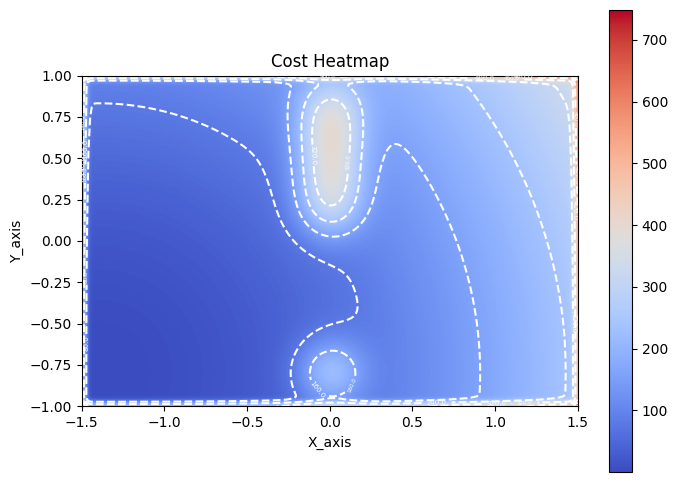

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Initialize a matrix to store the cost values
cost_matrix = np.zeros((300, 200))
X = np.linspace(-1.5, 1.5, 300)
Y = np.linspace(-1, 1, 200)

# Calculate the cost for each point in the grid
for i in range(200):
    for j in range(300):
        state = [X[j], Y[i]]
        cost_matrix[j, i] = state_cost(state, goal_points, obs_points)

# Create a DataFrame for the cost matrix
Cost_Map = pd.DataFrame(cost_matrix, index=list(X), columns=Y)

# Transpose the data for correct orientation in the heatmap
data_rotated = np.transpose(Cost_Map)

# Create a heatmap of the cost values
plt.figure(figsize=(8, 6))

# Display the heatmap
plt.imshow(data_rotated, extent=[X.min(), X.max(), Y.min(), Y.max()],
           origin='lower', cmap='coolwarm')
plt.colorbar()

# Add contour lines to the heatmap
contours = plt.contour(X, Y, data_rotated, levels=10, colors='white', linestyles='dashed')

# Label the contour lines with values
plt.clabel(contours, inline=True, fontsize=4, fmt='%1.1f')

# Customize the contour labels
plt.clabel(contours, inline=True, fontsize=5, fmt='%1.1f')

# Add axis labels and a title
plt.xlabel('X_axis')
plt.ylabel('Y_axis')
plt.title('Cost Heatmap')

# Display the plot
plt.show()


Da un'attenta analisi della heatmap notiamo che la funzione di costo tende ad assumere valori più elevati in corrispondenza della presenza di ostacoli. Questa funzione di costo considera la distanza euclidea tra la posizione del robot corrente(il suo stato) e la posizione finale di arrivo, proporzionando in base al valore di quest'ultima il valore della funzione di costo. Inoltre questa funzione di costo tiene conto anche della presenza degli ostacoli grazie alla presenza del termine gauss_sum ed infine tiene conto anche della presenza di alcune aree critiche per il robot, ovvero le aree di boundaries, presenti nelle zone estremanti della heatmap.
In virtu di ciò possiamo dedurre da questa prima analisi che si tratta di una buona funzione di costo.

# WP2

In [13]:
#WP2: Simulate (4 experiments) and visualize each robot's trajectory

## Simulation

Di seguito vengono proposte varie condizioni iniziali oltre a quelle fornite per le quali vengono effettuate le simulazioni dell'algoritmo del robotarium per fare in modo che il robot converga verso il goal_point desiderato.

In [14]:
# Initial conditions of the robot for 4 experiments
#initial_conditions è un caratterizzato da una matrice 4X3 dove ogni riga rappresenta la posizione iniziiale. Ogni posizione è caratterizzata da 3 componenenti che rappresentano
#la posizione iniziale lungo i rispettivi assi x ed y incluso la posizione dell'angolo thetha, che sarebbe l'angolo perpendicolare all'asse delle ruote.
#Questa forma prende il nome di "posizione della mano e nel nostro caso sono del tipo: [1.4,0.9],[0.2,0.9],[1.2,-0.5],[-1,0.9]" tutti con angolo theta pari a 0.
initial_conditions = [np.array(np.mat('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))] #Initial pose of the robots


In [ ]:
initial_conditions = [np.array(np.mat('1.4;-0.8; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))] 

In [ ]:
initial_conditions = [np.array(np.mat('1.4;-0.8; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))] 

Oltre a varie simulazioni con condizioni inizali diverse ne sono state effettuate anche altre con goal_point diversi per mettere maggiormente in risalto alcune criticità della funzione di costo fornitaci.

In [ ]:
goal_points = np.array(np.mat('-1.0; 0.4; 0')) 

In [ ]:
goal_points = np.array(np.mat('-1.0; 0.8; 0')) #Caso critico perchè l’algoritmo non converge.

In [ ]:
goal_points = np.array(np.mat('-1.0; 0.6; 0')) #Problemi con la traiettoria arancione, il robotarium con quest’ultima non converge

In [ ]:
goal_points = np.array(np.mat('-1.0; 0.4; 0'))

Tramite la seguente cella eseguiremo vari esperimenti grazie al tool Robotarium

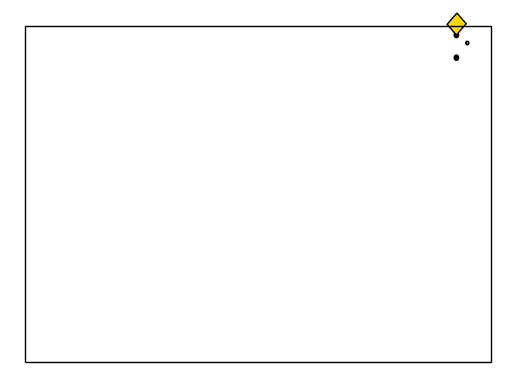

##### DEBUG OUTPUT #####
Your simulation will take approximately 44 real seconds when deployed on the Robotarium. 

	 Simulation had 1171 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

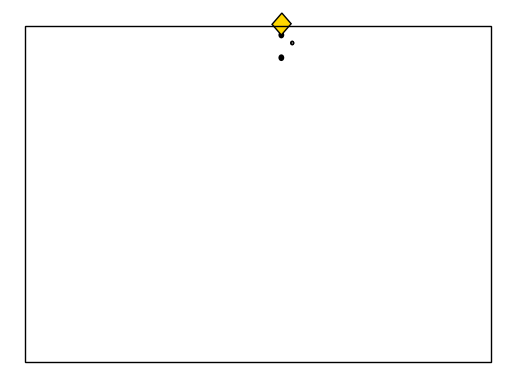

##### DEBUG OUTPUT #####
Your simulation will take approximately 45 real seconds when deployed on the Robotarium. 

	 Simulation had 2345 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

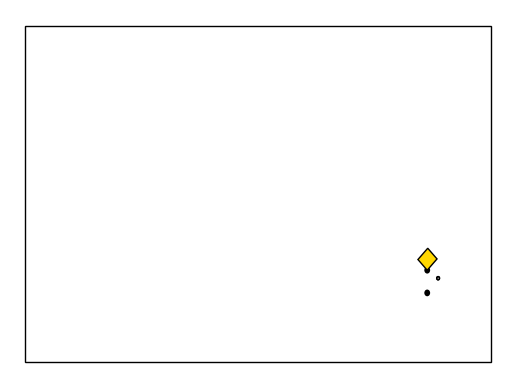

##### DEBUG OUTPUT #####
Your simulation will take approximately 37 real seconds when deployed on the Robotarium. 

	 Simulation had 3322 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

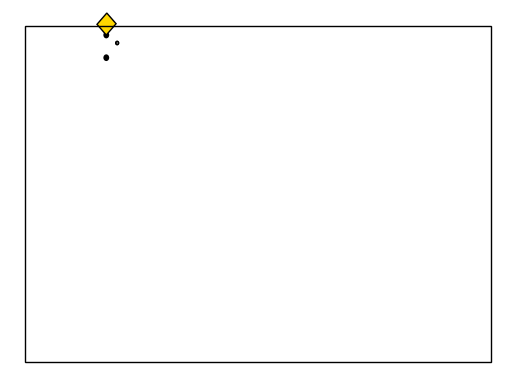

##### DEBUG OUTPUT #####
Your simulation will take approximately 25 real seconds when deployed on the Robotarium. 

	 Simulation had 3951 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

In [15]:
# Instantiate Robotarium object
N = 1 #Amount of robots per simulation

#numeri di esperimenti
N_experiment = 4
# X_si is going to be two-dimensional state history
X_Si = [0]*N_experiment
# D_Xi is going to be two-dimensional inputs history
D_Xi = [0]*N_experiment

# This first for loop creates the initial conditions
for I in range(N_experiment):

    #rappresenta l'insieme degli stati del sistema (posizione, orientamento, ecc.) per ciascun passo temporale durante l'esecuzione dell'algoritmo di controllo. 
    X_si = []
    #Questa variabile rappresenta l'insieme delle azioni di controllo (input) per ciascun passo temporale durante l'esecuzione dell'algoritmo di controllo. 
    D_xi = []

    #la seguente funzione prende in ingresso il numero di robot da far entrare nella simulazione dell'ambiente Robotarium, un parametro che 
    #indica se si deve mostrare a video come output una figura rappresentante la posizoione del robot, un vettore di condizioni iniziali
    #e un parametro che indica se la simulazione deve essere eseguita in tempo reale o meno. 
    r = robotarium.Robotarium(number_of_robots=N, show_figure=True, initial_conditions=initial_conditions[I], sim_in_real_time=False)

    # Create mapping from the control inputs to the actual velocity commands to the unicycle
    # Note: this is a very practical situation (robots often provide transformation functions to low level commands)
    si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion() #Converts single integrator inputs to unicycle inputs (low-level controller)
    _, uni_to_si_states = create_si_to_uni_mapping()
    
    # define x initially
    x = r.get_poses()
    x_si = uni_to_si_states(x)

    # Plotting Parameters
    CM = np.random.rand(N+10,3) # Random Colors
    goal_marker_size_m = 0.15
    obs_marker_size_m = 0.15
    marker_size_goal = determine_marker_size(r,goal_marker_size_m)
    marker_size_obs = determine_marker_size(r,obs_marker_size_m)
    font_size = determine_font_size(r,0.1)
    line_width = 5

    # Create Goal Point Markers
    #Text with goal identification
    goal_caption = ['G{0}'.format(ii) for ii in range(goal_points.shape[1])]
    #Plot text for caption
    goal_points_text = [r.axes.text(goal_points[0,ii], goal_points[1,ii], goal_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(goal_points.shape[1])]
    goal_markers = [r.axes.scatter(goal_points[0,ii], goal_points[1,ii], s=marker_size_goal, marker='s', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width,zorder=-2)
    for ii in range(goal_points.shape[1])]

    #Text with goal identification
    obs_caption = ['OBS{0}'.format(ii) for ii in range(obs_points.shape[1])]
    #Plot text for caption
    obs_points_text = [r.axes.text(obs_points[0,ii], obs_points[1,ii], obs_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(obs_points.shape[1])]
    obs_markers = [r.axes.scatter(obs_points[0,ii], obs_points[1,ii], s=marker_size_obs, marker='s', facecolors='none',edgecolors=CM[ii+1,:],linewidth=line_width,zorder=-2)
    for ii in range(obs_points.shape[1])]

    r.step()
    # While the robot is away from the objective ...
    #con il seguente ciclo while inizia la vera e proprie simulazione del Robotarium. Come condizione del ciclo while verrà usara una general stopping condition.
    #In particolare, il ciclo while continuerà a eseguire la simulazione fintanto che il numero di robot che si trovano in posizione vicino al goal_points
    #sarà diverso dal numero totale di robot presenti nell'ambiente di simulazione.Ovvero in altre parole ci sarà almeno un robot che sarà arrivato a 
    #destinazione. 
    while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, position_error=0.15,rotation_error=100)) != N):
        # Get poses of agents
        #Viene presa la posa degli agenti. 
        x = r.get_poses()
        #stato attuale del sistema espresso in coordinate di stato singolo (Single Integrator)
        x_si = uni_to_si_states(x)

        #Add to the dataset
        X_si.append(x_si)

        # The lines below define the pdf of the robot 
        #covarianza della pdf del robot. Specifica quanto l'incertezza è presente nei movimenti del sistema.
        cov = np.array([[0.001, 0.0002], [0.0002, 0.001]]) 
        #rappresenta una distribuzione di probabilità (PDF) multivariata normale basata sullo stato attuale del sistema
        x_pdf = st.multivariate_normal(x_si.reshape((2,)),cov) 
        x_sample = x_pdf.rvs() #Noisy state

        # This is about plotting
        #Per questioni di plotting vengono settati dei marker sia per i goal point che per gli obstacle points.
        for j in range(goal_points.shape[1]):
            goal_markers[j].set_sizes([determine_marker_size(r, goal_marker_size_m)])

        for j in range(obs_points.shape[1]):
            obs_markers[j].set_sizes([determine_marker_size(r, obs_marker_size_m)])

        # Task: compute the action from the policy. Call the variable dxi: 
        # this is the action sampled from the optimal solution to the control problem
        #La seguente variabile rappresenta l'azione di controllo (input) per uno specifico passo temporale durante l'esecuzione dell'algoritmo di controllo.
        dxi = Control_step(x_sample,U_space_1,U_space_2,goal_points,obs_points)

        D_xi.append(dxi)

        # Transform single integrator velocity commands to unicycle inputs (low level controller)
        #La seguente funzione prende in input l'azione di controllo (input) per uno specifico passo temporale durante l'esecuzione dell'algoritmo di controllo e lo stato del sistema (posizione, orientamento, ecc.) per uno specifico passo temporale durante l'esecuzione dell'algoritmo di controllo.
        dxu = si_to_uni_dyn(dxi, x)

        # Set the velocities inputs
        #Settiamo le velocità, facciamo lo step e ci salviamo un pò di storia per plottare successivamente. 
        r.set_velocities(np.arange(N), dxu)
        # Iterate the simulation
        r.step()
    #La seguente variabile rappresenta l'azione di controllo (input) per uno specifico passo temporale durante l'esecuzione dell'algoritmo di controllo.
    D_Xi[I] = D_xi
    #La seguente variabile rappresenta lo stato del sistema (posizione, orientamento, ecc.) per uno specifico passo temporale durante l'esecuzione dell'algoritmo di controllo.
    X_Si[I] = X_si

    #Call at end of script to print debug information and for your script to run on the Robotarium server properly
    #Riga che crea uno script.
    r.call_at_scripts_end()

Le seguenti cella serve per preparare le variabili per il plotting

In [16]:
XX = X_Si
UU = D_Xi

In [17]:
# Prepare data for plotting
X = []      # Initialize an empty list to store X values
X_plot = [] # Initialize an empty list to store X_plot values
U = []      # Initialize an empty list to store U values
U_plot = [] # Initialize an empty list to store U_plot values

# Iterate through each element in XX
for i in range(len(XX)):
    X.append(np.array(XX[i]))      # Append each element of XX as a NumPy array to X
    X_plot.append(np.array(XX[i])) # Append each element of XX as a NumPy array to X_plot

# Concatenate the list of NumPy arrays in X along axis 0 (row-wise) and reshape into a 2D array
X = np.concatenate(X, axis=0)
X = np.reshape(X, (-1, 2))

# Initialize an empty list to store U values
U = []

# Iterate through each element in UU
for i in range(len(UU)):
    U.append(np.array(UU[i]))      # Append each element of UU as a NumPy array to U
    U_plot.append(np.array(UU[i])) # Append each element of UU as a NumPy array to U_plot

# Concatenate the list of NumPy arrays in U along axis 0 (row-wise) and reshape into a 2D array
U = np.concatenate(U, axis=0)
U = np.reshape(U, (-1, 2))


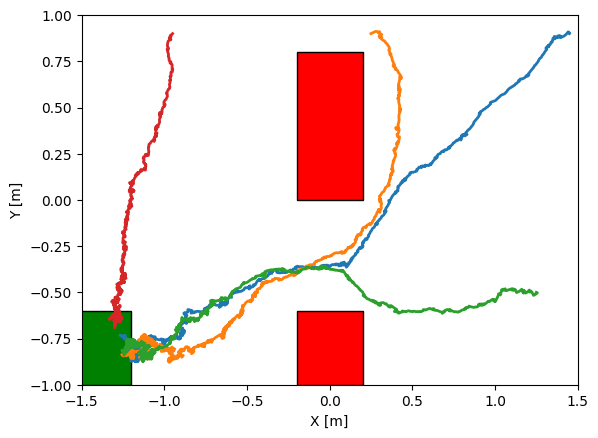

In [18]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

# Plot trajectories with different colors
plt.plot(X_plot[0][:, 0], X_plot[0][:, 1], linewidth=2)
plt.plot(X_plot[1][:, 0], X_plot[1][:, 1], linewidth=2)
plt.plot(X_plot[2][:, 0], X_plot[2][:, 1], linewidth=2)
plt.plot(X_plot[3][:, 0], X_plot[3][:, 1], linewidth=2)

# Draw obstacles
square1 = plt.Rectangle((-1.6, -1), 0.4, 0.4, fc='green', ec="black")
square3 = plt.Rectangle((-0.2, -1), 0.4, 0.4, fc='red', ec="black")
square2 = plt.Rectangle((-0.2, 0), 0.4, 0.8, fc='red', ec="black")

# Add the obstacle patches to the plot
plt.gca().add_patch(square2)
plt.gca().add_patch(square1)
plt.gca().add_patch(square3)

# Set plot limits and labels
plt.ylim(-1, 1)
plt.xlim(-1.5, 1.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

# Save the plot as an image file
plt.savefig('Training_Trajectories.jpg', dpi=1000, bbox_inches='tight')


Dal seguente plot notiamo che utilizzando la funzione di costo fornita, il robot riesce a raggiungere il goal_point evitando gli obs_point anche partendo da varie condizioni iniziali diverse.Tuttavia ci sono delle situazioni critiche per le quali il robot non riesce a convergere verso il goal_point e questo accade quando la condizione iniziale di interesse si trova vicino all'ostacolo. In questa situazinoe l'algoritmo rimane incastrato in un minimo locale, e di conseguenza non converge mai verso la soluzione ottimale(la cella del robotarium anche dopo ore non finisce la sau esecuzione).

# WP3

In [19]:
##### WP3: Reverse engineer the features and visualize them #####


In [20]:
#Redefining the feature points on the robotarium grid
obs_points_f = np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))

Dopo aver effettuato il reverse engineering delle feature si elencano di seguito i parametri in base al quale si baseranno le successive considerazioni nell'analisi della funzione.
- **Rilevanza:** Le caratteristiche devono catturare in modo appropriato gli aspetti critici dell'ambiente del robot, come la prossimità all'obiettivo e agli ostacoli. Questa rilevanza assicura che il robot prenda decisioni basate sulle sue circostanze.
- **Scalabilità:** La capacità della funzione di gestire diversi numeri di caratteristiche in modo efficace e di adattarsi a varie configurazioni di ostacoli o complessità dell'ambiente è cruciale. La scalabilità dell'insieme di caratteristiche è essenziale per la sua applicabilità in scenari diversi.
- **Sensibilità ai Parametri:** La scelta dei parametri, come la matrice di covarianza,la quale è utilizzata per definire la dispersione statistica delle variabili casuali coinvolte nel calcolo delle caratteristiche, e la metrica della distanza, può influenzare significativamente i calcoli delle caratteristiche. Pertanto, è essenziale regolare attentamente questi parametri per garantire che le caratteristiche riflettano accuratamente gli obiettivi del robot.
- **Adattabilità:** Le caratteristiche dovrebbero essere adattabili a cambiamenti nell'ambiente o negli ostacoli dinamici. Un insieme robusto di caratteristiche dovrebbe consentire al robot di rispondere in modo efficace a cambiamenti dinamici, garantendo una navigazione fluida ed efficiente anche in ambienti incerti o in evoluzione.

La funzione calcola un insieme di caratteristiche basate sulla funzione di densità di probabilità gaussiana, calcolata utilizzando la funzione **`my_logpdf`**. Ogni caratteristica rappresenta la densità di probabilità dello stato rispetto a punti specifici, inclusi i punti di destinazione e gli ostacoli. Ecco i punti chiave per l'analisi critica:

1. **Caratteristica di Prossimità all'Obiettivo (Caratteristica 0):** La prima caratteristica misura la distanza euclidea tra lo stato attuale e i punti di destinazione. Questa caratteristica incoraggia il robot a ridurre al minimo la distanza dall'obiettivo, promuovendo la convergenza nella posizione desiderata. Nel caso di un robot unicylce, è fondamentale avere informazioni sulla distanza dall'obiettivo per guidare il comportamento del robot nella direzione corretta.
2. **Caratteristiche di Prossimità agli Ostacoli (Caratteristica 1 a N):** Queste caratteristiche rappresentano la densità di probabilità dello stato rispetto a ciascun punto di ostacolo. La funzione calcola la funzione di densità di probabilità gaussiana multivariata per ciascun punto di ostacolo, utilizzando una matrice di covarianza predefinita. Ciò consente al robot di valutare la sua prossimità agli ostacoli e di evitare di avvicinarsi ad essi. Includendo gli ostacoli nell'insieme di caratteristiche, la funzione penalizza il robot per essere vicino o muoversi verso questi punti.
3. **Scelte di progettazione adattabili:** :La flessibilità della funzione, con il parametro N_feature che rappresenta il numero di caratteristiche, è particolarmente utile. Ciò consente di aggiungere o rimuovere facilmente caratteristiche a seconda dei requisiti specifici di navigazione del robot.
4. **Adattabilità a diverse configurazioni di ostacoli e obiettivi:**  :La funzione è progettata per essere adattabile a diverse configurazioni di ostacoli e obiettivi. Questo è importante in scenari dinamici in cui la disposizione degli ostacoli può variare nel tempo.

Per i motivi sopra elencati possiamo concludere che la funzione delle feature è una buona funzione di feature.


features(next_state, goal_points,obs_points N_feature) = my_logPDF[$\frac{1}{\sqrt{2\pi}\sigma} exp\left(-\frac{1}{2\sigma^2}(x - \mu)^2\right)$]

In [23]:
# Task: reverse engineer the features and critically discuss them
#np.size calcola il numero di colonne della matrice obs.
#Il numero di feature è determinato dalla dimensione dell'array obs_points_f
N_feature = np.size(obs_points_f,axis=1)+1 #rappresenta il numero totale di caratteristiche considerate nella funzione "feature".  
#Questo parametro è importante poiché determina la dimensione dell'array che memorizza le caratteristiche calcolate per lo stato successivo del robot. 
# La variabile N_feature consente di gestire in modo dinamico il numero di caratteristiche da considerare nel contesto del problema di controllo del robot e può essere regolata in base alle esigenze 
# specifiche dell'applicazione. Svolge un ruolo cruciale nel determinare la complessità delle caratteristiche considerate nella funzione "feature" e consente di adattare dinamicamente 
# il numero di attributi in base al contesto e agli obiettivi specifici del controllo del robot.

#Questa funzione "feature" viene utilizzata per calcolare e restituire un vettore di caratteristiche basato sullo stato successivo del robot, i punti obiettivo e i punti degli ostacoli.
def feature(next_state,goal_points,obs_points,N_feature): #>vettore h()
    """_summary_

    Args:
        next_state (_type_): stato successivo del robot 
        goal_points (_type_):  punti obiettivo
        obs_points (_type_): punti degli ostacoli 
        N_feature (_type_): numero delle feature

    Returns:
        array: restituisce l'array delle caratteristiche, che contiene la distanza dall'obiettivo come prima caratteristica e i valori delle funzioni di densità di probabilità per ciascun punto di ostacolo come caratteristiche successive.
   """
    v = np.array([0.025, 0.025], dtype=np.float32) #inizializza un array v contenente valori di varianza per la creazione della matrice di covarianza per la distribuzione normale multivariata.
    covar = np.diag(v) #genera la matrice di covarianza utilizzando l'array v appena creato.
    features = np.zeros(N_feature) #inizializza un array di zeri con dimensione pari al numero di caratteristiche N_feature.
    # calcola la funzione di densità di probabilità logaritmica per ciascun punto di ostacolo, utilizzando la funzione my_logpdf, e aggiorna gli elementi corrispondenti nell'array features.  
    for i in range(np.size(obs_points,axis=1)): 
        # (Calculation of logarithm of PDF)
        features[i+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar) 
        # features per ciasun punto di ostacolo.
    # ... (Calculation of Euclidean distance between next_state and goal_points)
    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2)) 
 
    return features 

# WP4

In [ ]:
##### WP4: using the previously defined features solve the inverse optimal control problem. 
#          Plot the estimated cost. 
#          Verify that the estimated cost allows the robot to complete the task #####

Il codice fornito risolver un problema di ottimizzazione convessa  per apprendere i pesi della funzione di costo utilizzando la libreria cvxpy

In [24]:
%%capture
'''
Solving the convex optimisation problem to learn the cost.
'''
import cvxpy as cp
import numpy as np
import time
#Viene calcolata la dimensione dell'insieme di dati X (traiettorie del robot), sottraendo 1 per ottenere il numero di istanze
M = np.size(X,axis=0) - 1
#Viene definita la variabile w, variabile di ottimizzazione di (1,N_feature), come vettore di pesi da ottimizzare. 
w = cp.Variable((1,N_feature)) 
#impostiamo il vincolo che i pesi w devono essere maggiori o uguali a zero.
constraints = [w >= 0]
#Vengono inizializzate alcuni array necessari per la risoluzione del problema di ottimizzazione
R = np.zeros((99,1))
L = []
# Initialize arrays for results and expectations
f_expect = np.zeros((2,20))
feature_sampled = np.zeros((N_feature,M))
PF = np.zeros((control_space_size,control_space_size,M))
#Viene eseguito un loop su ogni istanza di dati(traiettoria del robot). All'interno del loop, vengono calcolate diverse quantità, tra cui la probabilità di divergenza di Kullback-Leibler (DKL), 
# le feature campionate e le feature attese. Successivamente, viene formulato un termine del log-likelihood per ciascuna istanza (l) e aggiunto a una lista L.
# Loop through each data instance
for i in range(M):

    #############################################################################################################################
    # Calculate features and expectations
    #inizializzazone del vettore di feature
    features = np.zeros((N_feature,control_space_size,control_space_size))
    #viene definito un vettore per memorizzare la variabile che tiene conto dello stato del robot di dimensione pari ad X 
    state = np.array(X[i,:]) #Get the state
    #manipolazione della variabile che tiene conto dello stato iniziale
    x0 = state.reshape(-1,1)
    #inizializzazione del time_step al valore predefinito
    time_step = 0.033


    pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
    # Nested loop to compute features and Kullback-Leibler divergence probabilities
    for j in range(control_space_size):
        for k in range(control_space_size):
            #utilizzo della funzione model_step per computare il prossimo stato
            next_state = model_step(state,[U_space_1[j],U_space_2[k]],time_step)
            #calcolo della covarianza: L'elemento in posizione (0, 0) (prima riga, prima colonna) è 0.001, rappresenta la varianza della prima variabile. 
            # L'elemento in posizione (1, 1) (seconda riga, seconda colonna) è 0.001, rappresenta la varianza della seconda variabile.
            # Gli elementi in posizione (0, 1) e (1, 0) (prima riga, seconda colonna e viceversa) sono entrambi 0.0002, rappresentano la covarianza tra le due variabili. 
            #Facciamo riferimento a due variabili perchè lo stato tiene conto di due variabili essendo bidimensionale.
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            #calcolo della normale multivariata 
            f = st.multivariate_normal(next_state.reshape((2,)),cov) 
            next_sample = f.mean

            N_samples = 5
            #vengono generati N_samples campioni casuali dalla normale multivariata
            next_samples = f.rvs(N_samples)
            #inizializzazione del vettore di feature
            feature_sample = np.zeros((N_feature,N_samples))

            #per ogni campione vengono calcolate le feature
            for m in range(N_samples):
                feature_sample[:,m] = feature(next_samples[m,:],goal_points,obs_points_f,N_feature)

            features[:,j,k] = np.mean(feature_sample,axis=1)

            # Calculate Kullback-Leibler divergence probability
            log_DKL = np.exp(-(-f.entropy()))
            pf[j,k] = log_DKL
    PF[:,:,i] = pf
    #manipolazione delle feature
    features = np.reshape(features,(N_feature,control_space_size**2))

    f_sampled = model_step(state,U[i+1,:],time_step)
    cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
    f1 = st.multivariate_normal(f_sampled.reshape((2,)),cov)
    next_samples_f1 = f1.rvs(N_samples)
    feature_sample_f1 = np.zeros((N_feature,N_samples))
    # Calculate features for sampled state
    for n in range(N_samples):
        feature_sample_f1[:,n] = feature(next_samples_f1[n,:],goal_points,obs_points_f,N_feature)

    feature_sampled[:,i] = np.mean(feature_sample_f1,axis=1)
    

    # # Task: solve, using cvx the convex optimization problem we saw in class. To do so:
    # # (i) prepare each individual term of the summation, say l;
    # # # (ii) sum all the elements to define the cost function
    # # # (iii) solve the problem
    # Calculate log-likelihood term for each instance and add to the list L
    l = -(w @ feature_sampled[:,i]) + cp.log_sum_exp(cp.reshape(w @ features,(control_space_size,control_space_size)) + cp.log(PF[:,:,i]))
    ##PF[:,i] è un vettore che rappresenta la funzione di densità di probabilità della distribuzione target. 
    #  questa linea di codice calcola la differenza tra i valori attesi e campionati delle caratteristiche moltiplicati per i pesi, insieme alla funzione di densità di probabilità della distribuzione target. Il risultato rappresenta la quantità che deve essere minimizzata nel problema di ottimizzazione.
    L.append(l) #Log likelihood for each instance
#Viene definita la funzione obiettivo come la somma dei log-likelihood per ogni istanza. 
# Define the objective as the sum of log-likelihood terms
objective = cp.Minimize(cp.sum(L))
# Create an optimization problem
prob = cp.Problem(objective)
# Solve the optimization problem
result = prob.solve(verbose = False)

# Print optimization results
print("status:", prob.status)
print("optimal value", prob.value)

In [25]:
# Show the values: critically discuss if these weights make sense
weights = w.value
print('weights:',weights)

weights: [[-10.20373957  -4.91642806   0.05372807  -0.70316395 -10.77920342
   -5.5344739   -0.62440177  -0.48366245  -0.16682255   0.23429188
    1.27335551  -0.08559923   0.08155456  -1.80712843  -0.13961222
   -0.04730787]]



Per l'analisi dei pesi verranno osservati i seguenti punti:

1. **Segno dei Pesi:**  La maggior parte dei pesi è negativa, indicando che il modello sta assegnando un impatto negativo alle caratteristiche considerate. Il modello tende a penalizzare queste caratteristiche nella stima della funzione di costo.

2. **Magnitudine dei Pesi:** La magnitudine dei pesi varia notevolmente, con alcuni pesi molto grandi in valore assoluto. Ad esempio, i primi due pesi sono di un ordine di grandezza superiore rispetto agli altri. Questo suggerisce che queste due caratteristiche hanno un impatto significativo sulla funzione di costo. Si suppone che in questa fase quei pesi siano relativi a feature che devono svalutare la funzione ad avvicinarsi agli ostacoli.

3. **Consistenza con le Aspettative:** Dal momento che ci troviamo nel contesto di ottimizzazione dell'IOC nel caso del robot unicycle possiamo aspettarci pesi negativi, in quanto non devono invogliare la funzione a convergere in determinate configurazioni dello spazio che sono quelle degli ostacoli

4. **Esperimenti e Validazione:** In seguito per validare la bontà della nostra analisi eseguiremo un'analisi approfondita della funzione di costo ricostruita.

In [26]:
# Check the status of the optimization problem: did the optimization go well?
print("status:", prob.status)
print("optimal value", prob.value)

status: optimal
optimal value -8973.725023102132


Nel seguente codice verrà riformattata la mappa origiaria del costo, utile per scopi di plotting.

In [27]:
# Reformatting the original cost map (just for checking and plotting purposes)

import numpy as np  # Importing NumPy library for numerical operations
import scipy.stats as st  # Importing SciPy's stats module for statistical functions
import pandas as pd  # Importing Pandas library for data manipulation and analysis

goal_points = np.array(np.mat('-1.4; -0.8; 0'))  # Defining goal points as a 3D column matrix

# obs_points = np.array(np.mat('0 0 0 0 0 0;0 0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0 0'))
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))  # Defining obstacle points as a 3x5 matrix

def state_cost(state, goal_points, obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)  # Defining a 2D array of variances
    covar = np.diag(v)  # Creating a diagonal covariance matrix using variances

    gauss_sum = 0  # Initializing a variable to store the sum of Gaussian components

    for i in range(np.size(obs_points, axis=1)):  # Looping through obstacle points
        gauss_sum += 20 * my_logpdf(state[:2], obs_points[:2, i], covar)  # Accumulating Gaussian components

    cost = 30 * ((state[0] - goal_points[0]) ** 2 + (state[1] - goal_points[1]) ** 2) + gauss_sum  # Computing the total cost
    return cost

Cost_Map = np.zeros((300, 200))  # Initializing a 2D array to store the cost map
X_axis = np.linspace(-1.5, 1.5, 300)  # Generating X-axis values
Y_axis = np.linspace(-1, 1, 200)  # Generating Y-axis values

for i in range(200):
    for j in range(300):
        state = np.array([X_axis[j], Y_axis[i]])  # Creating a state vector based on X and Y values
        Cost_Map[j, i] = state_cost(state, goal_points, obs_points)  # Computing the cost for each grid point

Coat_Map = pd.DataFrame(Cost_Map, index=list(X_axis), columns=Y_axis)  # Creating a DataFrame with the computed cost map


In [28]:
# Computing the reconstructed cost map

import numpy as np  # Importing NumPy library for numerical operations
import scipy.stats as st  # Importing SciPy's stats module for statistical functions

goal_points = np.array(np.mat('-1.4; -0.8; 0'))  # Defining goal points as a 3D column matrix

def state_cost_estimated(state, goal_points, obs_points, weights):
    v = np.array([0.025, 0.025], dtype=np.float32)  # Defining a 2D array of variances
    covar = np.diag(v)  # Creating a diagonal covariance matrix using variances

    gauss_sum = 0  # Initializing a variable to store the sum of Gaussian components

    for i in range(np.size(obs_points, axis=1)):  # Looping through obstacle points
        gauss_sum += -weights[:, i + 1] * my_logpdf(state[:2], obs_points[:2, i], covar)  # Accumulating Gaussian components

    # Computing the total cost based on estimated weights
    cost = -weights[:, 0] * (((state[0] - goal_points[0]) ** 2 + (state[1] - goal_points[1]) ** 2)) + gauss_sum
    return cost

Cost_Map = np.zeros((300, 200))  # Initializing a 2D array to store the reconstructed cost map
X_axis = np.linspace(-1.5, 1.5, 300)  # Generating X-axis values
Y_axis = np.linspace(-1, 1, 200)  # Generating Y-axis values

for i in range(200):
    for j in range(300):
        state = np.array([X_axis[j], Y_axis[i]])  # Creating a state vector based on X and Y values
        Cost_Map[j, i] = state_cost_estimated(state, goal_points, obs_points_f, weights)  # Computing the cost for each grid point


/var/folders/h8/_fxskz7s2_j0ywzp2t4cqg900000gn/T/ipykernel_4563/1897867411.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticklabels)
/var/folders/h8/_fxskz7s2_j0ywzp2t4cqg900000gn/T/ipykernel_4563/1897867411.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


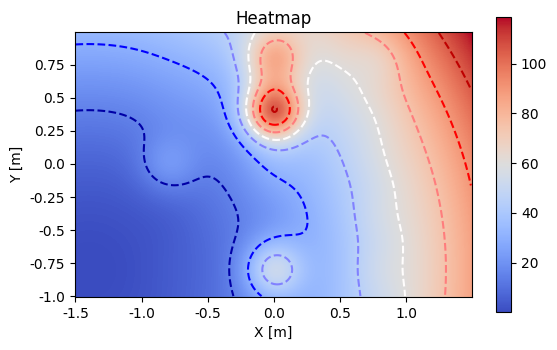

<Figure size 640x480 with 0 Axes>

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Transpose the data array to rotate the heatmap
data_rotated = np.transpose(Cost_Map)

# Task: plot the reconstructed cost
# Create a figure and axes
fig, ax = plt.subplots()

# Create a heatmap using imshow()
heatmap = ax.imshow(data_rotated,cmap='coolwarm')

contours = ax.contour(data_rotated,cmap='seismic' , linestyles='dashed')

# Add a colorbar
cbar = plt.colorbar(heatmap,shrink=0.8)

# Add labels and title
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('Heatmap')

ax.invert_yaxis()

# Define the desired tick positions and labels for x and y axes
x_ticklabels = np.arange(-2, 2, 0.5)  # Example: custom tick labels for x-axis
y_ticklabels = np.arange(-1.25, 1.25, 0.25)  # Example: custom tick labels for y-axis

# setta asse x e y
ax.set_xticklabels(x_ticklabels)
ax.set_yticklabels(y_ticklabels)

# plotta 
plt.show()
plt.savefig('Cost_Heat_Map_Actual.jpg',dpi=1000,bbox_inches ='tight')

<Figure size 2000x1000 with 0 Axes>

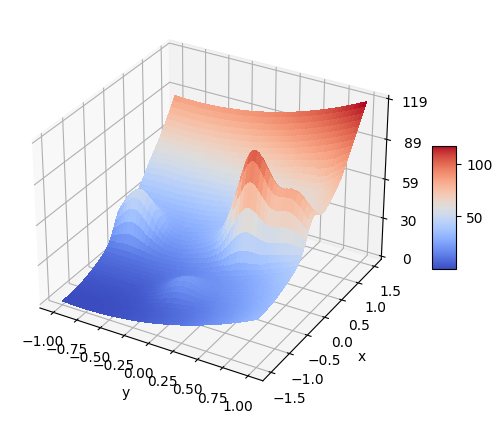

In [30]:
import matplotlib.pyplot as plt  # Importing the Matplotlib library for plotting
from matplotlib import cm  # Importing the color map module from Matplotlib
from matplotlib.ticker import LinearLocator  # Importing the LinearLocator module from Matplotlib
import numpy as np  # Importing NumPy library for numerical operations

fig = plt.figure(figsize=(20, 10))  # Creating a new figure with a specified size
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})  # Creating a 3D subplot within the figure
fig.figure.set_figheight(20)  # Setting the figure height

X_axis = np.linspace(-1.5, 1.5, 300)  # Generating X-axis values
Y_axis = np.linspace(-1, 1, 200)  # Generating Y-axis values
X, Y = np.meshgrid(Y_axis, X_axis)  # Creating a meshgrid for X and Y values

# Plotting the surface using the Cost_Map values with specified colormap and properties
surf = ax.plot_surface(X, Y, Cost_Map, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customizing the z-axis properties
# ax.set_zlim(-1.01, 1.01)  # Uncomment and customize if needed
ax.zaxis.set_major_locator(LinearLocator(5))  # Setting major locator for the z-axis
ax.zaxis.set_major_formatter('{x:.0f}')  # Setting major formatter for the z-axis

ax.set_xlabel('y')  # Labeling the x-axis
ax.set_ylabel('x')  # Labeling the y-axis

# Uncomment and customize if needed
# ax.view_init(90, 0)  # Setting the view angle for the 3D plot

# Adding a color bar to the plot
fig.colorbar(surf, shrink=0.08, aspect=5)

plt.show()  # Displaying the plot
# plt.savefig('Cost_Map_estimated.jpg', dpi=1000, bbox_inches='tight')  # Uncomment to save the plot as an image file


In [31]:
def Control_step(state, U_space_1, U_space_2, goal_points, obs_points, weights):
    target_pf = 1 / control_space_size**2  # Target probability density function (pf) for a uniform distribution
    time_step = 0.033  # Time step for the Robotarium simulation

    pf = np.zeros((control_space_size, control_space_size))  # Initialize the probability density function (pf)

    for i in range(control_space_size):
        for j in range(control_space_size):
            # Simulate the next state using the model_step function
            next_state = model_step(state, [U_space_1[i], U_space_2[j]], time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])  # Covariance matrix for the multivariate normal distribution
            f = st.multivariate_normal(next_state.reshape((2,)), cov)  # Create a multivariate normal distribution

            N_samples = 20  # Number of samples
            next_sample = f.rvs(N_samples)  # Generate random samples from the distribution

            cost = 0  # Initialize the cost variable

            # Calculate the estimated state cost for each sample and average them
            for k in range(N_samples):
                cost += state_cost_estimated(next_sample[k, :], goal_points, obs_points, weights) / N_samples

            # Calculate the log density ratio (log_DKL) for the current state
            log_DKL = np.exp(-(-f.entropy()) - cost)
            pf[i, j] = log_DKL  # Update the probability density function (pf) matrix

    S2 = np.sum(pf)  # Calculate the sum of all probabilities in the pf matrix
    pf = np.divide(pf, S2)  # Normalize the pf matrix by dividing by the sum

    flat = pf.flatten()  # Flatten the pf matrix into a 1D array
    sample_index = np.random.choice(a=flat.size, p=flat)  # Choose an index based on the probability distribution

    adjusted_index = np.unravel_index(sample_index, pf.shape)  # Convert the flattened index to 2D indices
    action = np.reshape(np.array([U_space_1[adjusted_index[0]], U_space_2[adjusted_index[1]]]), (2, 1))

    return action  # Return the chosen action as a 2D array


Rieseguiamo la cella del Robotarium per verificare il corretto funzionamento della nostra funzione di costo, calcolata tramite l'IOC.

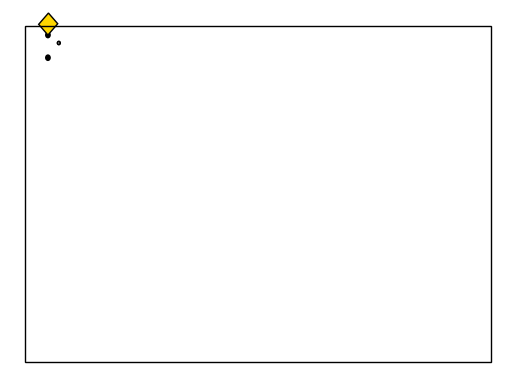

##### DEBUG OUTPUT #####
Your simulation will take approximately 79 real seconds when deployed on the Robotarium. 

	 Simulation had 6008 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

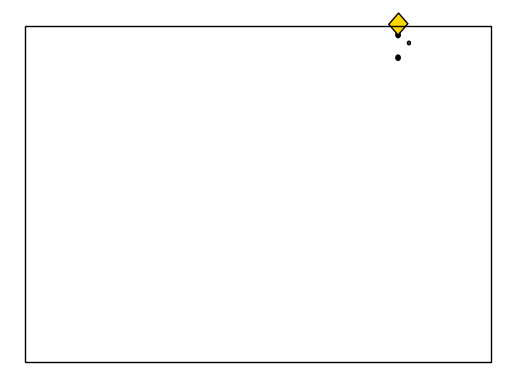

##### DEBUG OUTPUT #####
Your simulation will take approximately 91 real seconds when deployed on the Robotarium. 

	 Simulation had 8395 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

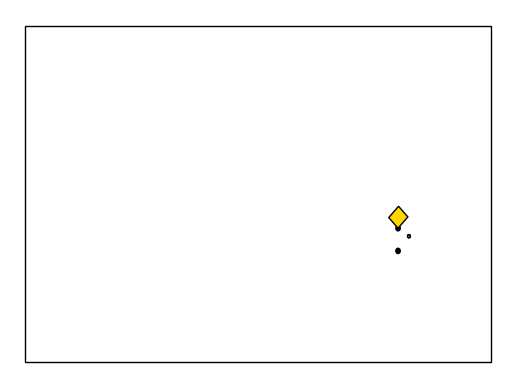

##### DEBUG OUTPUT #####
Your simulation will take approximately 177 real seconds when deployed on the Robotarium. 

	 Simulation had 13050 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

In [32]:
# Instantiate Robotarium object (start the robots from different initial conditions than the 4 experiments above)
N = 1
initial_conditions = [np.array(np.mat('-1.4;0.9; 0')),np.array(np.mat('1;0.9; 0')),np.array(np.mat('1;-0.25; 0'))]
N_experiment = 3
# Definitions as above...
X_Si = [0]*N_experiment
D_Xi = [0]*N_experiment

for I in range(N_experiment):

    X_si = []
    D_xi = []

    r = robotarium.Robotarium(number_of_robots=N, show_figure=True, initial_conditions=initial_conditions[I], sim_in_real_time=False)

    si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion()

    x = r.get_poses()
    x_si = uni_to_si_states(x)

    CM = np.random.rand(N+10,3) 
    goal_marker_size_m = 0.15
    obs_marker_size_m = 0.15
    marker_size_goal = determine_marker_size(r,goal_marker_size_m)
    marker_size_obs = determine_marker_size(r,obs_marker_size_m)
    font_size = determine_font_size(r,0.1)
    line_width = 5

    goal_caption = ['G{0}'.format(ii) for ii in range(goal_points.shape[1])]
    goal_points_text = [r.axes.text(goal_points[0,ii], goal_points[1,ii], goal_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(goal_points.shape[1])]
    goal_markers = [r.axes.scatter(goal_points[0,ii], goal_points[1,ii], s=marker_size_goal, marker='s', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width,zorder=-2)
    for ii in range(goal_points.shape[1])]

    obs_caption = ['OBS{0}'.format(ii) for ii in range(obs_points.shape[1])]
    obs_points_text = [r.axes.text(obs_points[0,ii], obs_points[1,ii], obs_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(obs_points.shape[1])]
    obs_markers = [r.axes.scatter(obs_points[0,ii], obs_points[1,ii], s=marker_size_obs, marker='s', facecolors='none',edgecolors=CM[ii+1,:],linewidth=line_width,zorder=-2)
    for ii in range(obs_points.shape[1])]

    r.step()
    # Task: re-implement the simulation loop this time using the policy with the estimated cost
    while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, position_error=0.15,rotation_error=100)) != N):

        # Get poses of agents
        x = r.get_poses()
        x_si = uni_to_si_states(x)

        #Add to the dataset
        X_si.append(x_si)

        # The lines below define the pdf of the robot 
        cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
        x_pdf = st.multivariate_normal(x_si.reshape((2,)),cov)
        x_sample = x_pdf.rvs() #Noisy state

        # This is about plotting
        for j in range(goal_points.shape[1]):
            goal_markers[j].set_sizes([determine_marker_size(r, goal_marker_size_m)])

        for j in range(obs_points.shape[1]):
            obs_markers[j].set_sizes([determine_marker_size(r, obs_marker_size_m)])

        # Task: compute the action from the policy. Call the variable dxi: 
        # this is the action sampled from the optimal solution to the control problem
        dxi = Control_step(x_sample,U_space_1,U_space_2,goal_points,obs_points,weights)

        D_xi.append(dxi)

        # Transform single integrator velocity commands to unicycle inputs (low level controller)
        dxu = si_to_uni_dyn(dxi, x)

        # Set the velocities inputs
        r.set_velocities(np.arange(N), dxu)
        # Iterate the simulation
        r.step()
      

    D_Xi[I] = D_xi
    X_Si[I] = X_si

    r.call_at_scripts_end()

Dall'esecuzione della cella del robotarium notiamo che il nuovo costo ricostruito consente al robot di eseguire il suo task

Come possiamo notare dalla corretta esecuzione della cella precedente , il costo ricostruito consente ancora al robot di eseguire il suo task.Come per il caso precedente, ovvero quella della funzione di costo nel FOC il robot è in grado di compiere il suo task , tuttavia sempre tramite prove effettuate con gli stessi dati di goal_point e obs_point si è verificato che le situazioni critiche che si verificavano nel caso precedente si verificano anche con il costo ricostruito

In [33]:
XX = X_Si
UU = D_Xi

In [34]:
#Initialize empty lists X, X_plot, U, and U_plot to store arrays
X = []
X_plot = []
U = []
U_plot = []
#Iterate through each element in the list XX. Convert each element into a NumPy array and append it to both X and X_plot. 
# The purpose of appending to both lists is unclear; X and X_plot seem identical.
for i in range(len(XX)):
    X.append(np.array(XX[i]))
    X_plot.append(np.array(XX[i]))
#Concatenate the arrays in X along axis 0, resulting in a 2D array. Reshape the array to have two columns.
X = np.concatenate(X, axis=0)
X = np.reshape(X, (-1, 2))
#Similar to the processing of XX, iterate through each element in the list UU. Convert each element into a NumPy array and append it to both U and U_plot. 
# As before, the purpose of appending to both lists is unclear.
U = []
for i in range(len(UU)):
    U.append(np.array(UU[i]))
    U_plot.append(np.array(UU[i]))
#Concatenate the arrays in U along axis 0, resulting in a 2D array. Reshape the array to have two columns
U = np.concatenate(U, axis=0)
U = np.reshape(U, (-1, 2))

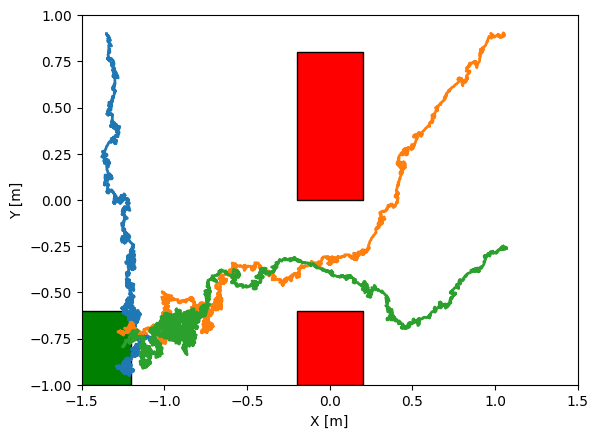

In [35]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

#Task: plot trajectories with different colors

plt.plot(X_plot[0][:,0],X_plot[0][:,1],linewidth=2)
plt.plot(X_plot[1][:,0],X_plot[1][:,1],linewidth=2)
plt.plot(X_plot[2][:,0],X_plot[2][:,1],linewidth=2)


#Draw obstacles
square1 = plt.Rectangle((-1.6,-1), 0.4, 0.4, fc='green',ec="black")
square3 = plt.Rectangle((-0.2,-1), 0.4, 0.4, fc='red',ec="black")
square2 = plt.Rectangle((-0.2,0), 0.4, 0.8, fc='red',ec="black")
plt.gca().add_patch(square2)
plt.gca().add_patch(square1)
plt.gca().add_patch(square3)
plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.savefig('Training_Trajectories.jpg',dpi=1000,bbox_inches ='tight')

# WP5

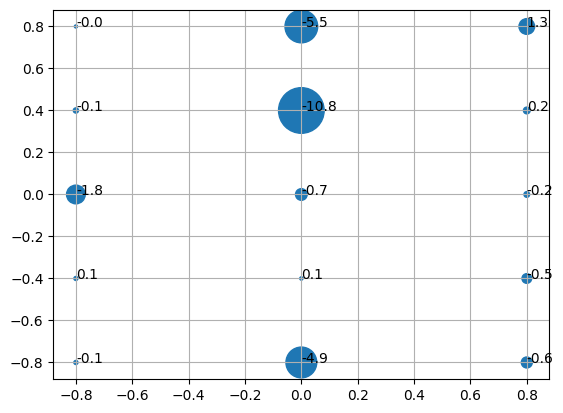

In [36]:
# Plotting feature points on the robotarium grid with correspopnding weights
#This code snippet creates a scatter plot of feature points on a grid, where each point is annotated with its corresponding weight. Let's break down the code:
import numpy as np
import matplotlib.pyplot as plt
#Create a scatter plot using obs_points_f, which presumably contains feature points. obs_points_f[0, :] and obs_points_f[1, :] are used as the x and y coordinates, respectively.
fig,ax = plt.subplots()

circle_sizes = np.abs(weights[:, 1:]) * 100  # Adjust the multiplier as needed
ax.scatter(obs_points_f[0, :], obs_points_f[1, :], circle_sizes)
#Initialize an array w of zeros. Then, iterate through the weights in the weights array (assuming it's a 2D array) and round each weight to one decimal place, storing the results in the w array.
w = np.zeros((15,))

for j in range(15):
    wt = float(weights[:,j+1])
    w[j] = round(wt,1)
#Annotate the scatter plot with the rounded weights. The enumerate function is used to iterate over both the weights (w) and the corresponding indices. The txt variable holds each weight, and ax.annotate is used to place each weight at the corresponding feature point.
for i, txt in enumerate(w.reshape(15,)):
    ax.annotate(txt,(obs_points_f[0,i],obs_points_f[1,i]))
#Add a grid to the plot and display the final plot.
plt.grid(True)
plt.show()

In [ ]:
weights

In [ ]:
# Comment the results you observe in the figure generated by the above cell


Come vediamo dal plot della figura soprastante, i pesi delle feature sono molto rappresentativi di quella che è la corrispondente distanza del robot dai punti che rappresentano gli ostacoli.
In particolar modo notiamo che questi tendono ad aumentare con l'avvicinarsi del robot a questi ultimi. Motivo per cui possiamo concludere che i pesi di queste feature sono sufficientemente rappresentativi per queste feature.

### Nuova funzione di costo

### Nuovo set di feature